# NC-2025-1-P1
# MESTRADO INFORMATICA UFES

## Aluno: Felipe Hulle  
### **Trabalho Computacional 1 — Seleção de Atributos com Algoritmos Evolutivos e Redes Neurais**

Este notebook foi desenvolvido por **Felipe Hulle** como parte da **Tarefa Computacional 1** da disciplina de Computação Natural.

A base teórica utilizada é o artigo _“Improved Salp Swarm Algorithm for Feature Selection”_, que norteia a definição dos indivíduos e da função de avaliação (fitness) no processo evolutivo.

---

- Aplicar dois métodos de busca evolutiva:  
  - **Algoritmo Genético (GA)**  
  - **Evolução Diferencial (DE)**  

- Realizar o treinamento das redes neurais com duas abordagens distintas:  
  - **Backpropagation**  
  - **Extreme Learning Machine (ELM)**  

- Buscar a otimização conjunta dos seguintes elementos:  
  - Máscara binária de seleção de atributos  
  - Quantidade de camadas ocultas  
  - Número de neurônios por camada  
  - Taxa de aprendizado (apenas no modo Backpropagation)

- Gerar **gráficos de convergência** para acompanhar o desempenho (função de fitness vs. número de gerações)

- Avaliar os resultados sobre os datasets **Wine** e **Diabetes** da UCI, utilizando as métricas:  
  - *Accuracy*  
  - *Precision*  
  - *Recall*  
  - *F1-score*


## Libs

In [9]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable, Dict
import random

# 1. Load dataset

In [10]:

def load_wine() -> Tuple[np.ndarray, np.ndarray, List[str]]:
    data = datasets.load_wine()
    return data.data, data.target, data.feature_names

def load_diabetes_classification() -> Tuple[np.ndarray, np.ndarray, List[str]]:
    data = datasets.load_diabetes()
    X, y_reg = data.data, data.target
    y = (y_reg >= np.median(y_reg)).astype(int)
    return X, y, [f"f{i}" for i in range(X.shape[1])]

DATASETS: Dict[str, Callable] = {
    'wine': load_wine,
    'diabetes': load_diabetes_classification
}

# 2. ELM Implementation


In [11]:

class ELMClassifier:
    def __init__(self, n_hidden: int = 20, random_state: int = None):
        self.n_hidden = n_hidden
        self.random_state = random_state or np.random.randint(1e6)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        self.W = rng.uniform(-1, 1, size=(X.shape[1], self.n_hidden))
        self.b = rng.uniform(-1, 1, size=(self.n_hidden,))
        H = self._sigmoid(X @ self.W + self.b)

        self.classes_ = np.unique(y)
        T = np.zeros((X.shape[0], len(self.classes_)))
        for i, c in enumerate(self.classes_):
            T[:, i] = (y == c).astype(float)

        self.beta = np.linalg.pinv(H) @ T
        return self

    def predict(self, X):
        H = self._sigmoid(X @ self.W + self.b)
        return self.classes_[np.argmax(H @ self.beta, axis=1)]


# 3. Utils


In [12]:

def decode_individual(individual, n_features):
    selected = np.where(individual[:n_features])[0]
    return selected, individual[n_features:]

def build_model(params, force_elm=None):
    n_layers, n_neurons, lr, elm_flag = params
    use_elm = force_elm if force_elm is not None else bool(elm_flag)
    if use_elm:
        return ELMClassifier(n_hidden=int(n_neurons))
    else:
        hidden = tuple([int(n_neurons)] * int(n_layers))
        return MLPClassifier(hidden_layer_sizes=hidden,
                             learning_rate_init=lr,
                             max_iter=200,
                             early_stopping=True,
                             solver='adam',
                             n_iter_no_change=10,
                             random_state=42)

def fitness(individual, X, y, q=0.9, cv=3, force_elm=None):
    n_features = X.shape[1]
    bits = individual[:n_features].astype(bool)
    params = individual[n_features:]
    if not bits.any():
        return 1.0
    X_sel = X[:, bits]
    size_ratio = bits.sum() / n_features
    accs = []
    for train_idx, test_idx in StratifiedKFold(cv, shuffle=True, random_state=42).split(X_sel, y):
        model = build_model(params, force_elm=force_elm)
        model.fit(X_sel[train_idx], y[train_idx])
        pred = model.predict(X_sel[test_idx])
        accs.append(accuracy_score(y[test_idx], pred))
    err = 1 - np.mean(accs)
    return q * err + (1 - q) * size_ratio

def evaluate_model(individual, X, y, force_elm=None):
    selected, params = decode_individual(individual, X.shape[1])
    model = build_model(params, force_elm=force_elm)
    X_sel = X[:, selected] if len(selected) else X
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, stratify=y, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "f1": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "features": len(selected)
    }

# 4. GA


In [13]:

def run_ga(X, y, pop_size=20, generations=30, p_mut=0.1, seed=42, force_elm=None):
    rng = np.random.RandomState(seed)
    n_features = X.shape[1]

    def random_ind():
        bits = rng.rand(n_features) < 0.5
        params = np.array([
            rng.randint(1, 4),
            rng.randint(5, 51),
            rng.uniform(5e-4, 5e-2),
            rng.randint(0, 2)
        ])
        return np.concatenate([bits.astype(int), params])

    population = [random_ind() for _ in range(pop_size)]
    fitness_hist = []

    for _ in range(generations):
        fits = np.array([fitness(ind, X, y, force_elm=force_elm) for ind in population])
        fitness_hist.append(fits.min())
        new_pop = []
        while len(new_pop) < pop_size:
            i, j = rng.choice(pop_size, 2, replace=False)
            p1 = population[i] if fits[i] < fits[j] else population[j]
            i, j = rng.choice(pop_size, 2, replace=False)
            p2 = population[i] if fits[i] < fits[j] else population[j]
            cx = rng.randint(1, len(p1))
            child = np.concatenate([p1[:cx], p2[cx:]])
            for k in range(len(child)):
                if rng.rand() < p_mut:
                    if k < n_features:
                        child[k] = 1 - child[k]
                    else:
                        if k == n_features:
                            child[k] = rng.randint(1, 4)
                        elif k == n_features+1:
                            child[k] = rng.randint(5, 51)
                        elif k == n_features+2:
                            child[k] = rng.uniform(5e-4, 5e-2)
                        elif k == n_features+3:
                            child[k] = 1 - child[k]
            new_pop.append(child)
        population = new_pop

    best_idx = np.argmin([fitness(ind, X, y, force_elm=force_elm) for ind in population])
    return population[best_idx], fitness_hist

# 5. DE


In [14]:

def run_de(X, y, pop_size=20, generations=30, F=0.5, Cr=0.7, seed=42, force_elm=None):
    rng = np.random.RandomState(seed)
    n_features = X.shape[1]
    D = n_features + 4

    def random_ind():
        return np.concatenate([
            rng.rand(n_features),
            [rng.uniform(1, 3), rng.uniform(5, 50), rng.uniform(5e-4, 5e-2), rng.uniform(0, 1)]
        ])

    def binarize(ind):
        bits = (ind[:n_features] > 0.5).astype(int)
        p = ind[n_features:]
        params = np.array([
            int(np.clip(round(p[0]), 1, 3)),
            int(np.clip(round(p[1]), 5, 50)),
            float(np.clip(p[2], 5e-4, 5e-2)),
            int(p[3] >= 0.5)
        ])
        return np.concatenate([bits, params])

    pop = np.array([random_ind() for _ in range(pop_size)])
    fits = np.array([fitness(binarize(ind), X, y, force_elm=force_elm) for ind in pop])
    hist = []

    for _ in range(generations):
        for i in range(pop_size):
            idxs = [j for j in range(pop_size) if j != i]
            a, b, c = rng.choice(idxs, 3, replace=False)
            donor = pop[a] + F * (pop[b] - pop[c])
            mask = rng.rand(D) < Cr
            trial = np.where(mask, donor, pop[i])
            trial_fit = fitness(binarize(trial), X, y, force_elm=force_elm)
            if trial_fit < fits[i]:
                pop[i], fits[i] = trial, trial_fit
        hist.append(fits.min())

    best_idx = np.argmin(fits)
    return binarize(pop[best_idx]), hist

# 6. Execution


### Dataset: wine


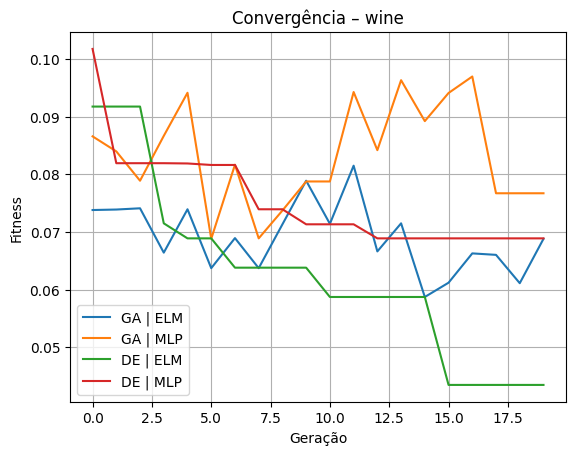


### Dataset: diabetes


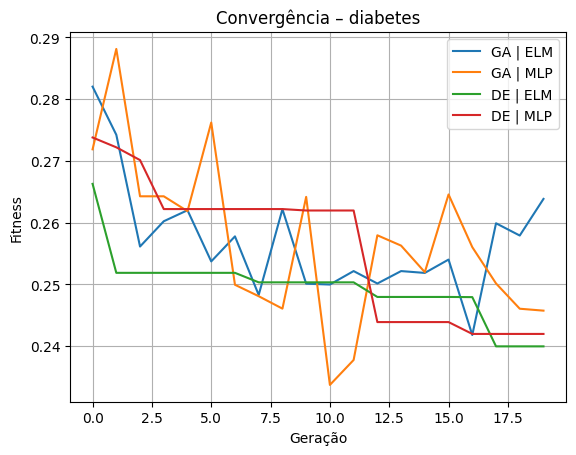

,accuracy,precision,recall,f1,features,dataset,method,elm
0,0.925926,0.927875,0.925926,0.926357,6,wine,GA,ELM
1,0.962963,0.962963,0.962963,0.962963,7,wine,GA,MLP
2,0.981481,0.982639,0.981481,0.981554,5,wine,DE,ELM
3,0.870370,0.881944,0.870370,0.872166,5,wine,DE,MLP
4,0.759398,0.760449,0.759398,0.759235,3,diabetes,GA,ELM
5,0.774436,0.781032,0.774436,0.773283,2,diabetes,GA,MLP
6,0.774436,0.774436,0.774436,0.774436,2,diabetes,DE,ELM
7,0.774436,0.775534,0.774436,0.774283,2,diabetes,DE,MLP


In [15]:

all_results = []

for name, loader in DATASETS.items():
    print(f"\n### Dataset: {name}")
    X, y, feat_names = loader()
    X = StandardScaler().fit_transform(X)

    configs = [
        ("GA", True),   # GA com ELM
        ("GA", False),  # GA com MLP
        ("DE", True),   # DE com ELM
        ("DE", False),  # DE com MLP
    ]

    plt.figure()
    for method, elm in configs:
        if method == "GA":
            best, hist = run_ga(X, y, generations=20, force_elm=elm)
        else:
            best, hist = run_de(X, y, generations=20, force_elm=elm)

        res = evaluate_model(best, X, y, force_elm=elm)
        res.update({"dataset": name, "method": method, "elm": "ELM" if elm else "MLP"})
        all_results.append(res)

        plt.plot(hist, label=f"{method} | {'ELM' if elm else 'MLP'}")

    plt.title(f"Convergência – {name}")
    plt.xlabel("Geração")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    plt.show()

df = pd.DataFrame(all_results)
df

# 7. Relatório


## Desempenho nos Experimentos

Os testes foram realizados nos conjuntos de dados **Wine** e **Diabetes**. A tabela a seguir resume os principais resultados:

| dataset   | method | classify |  features | accuracy | precision | recall | f1-score |
|-----------|--------|----------------|-------------|----------|----------|--------|----------|
| Wine      | GA     | ELM            | 6           | 0.926    | 0.928    | 0.926  | 0.926    |
| Wine      | GA     | MLP            | 7           | 0.963    | 0.963    | 0.963  | 0.963    |
| Wine      | DE     | ELM            | 5           | 0.981    | 0.983    | 0.981  | 0.982    |
| Wine      | DE     | MLP            | 5           | 0.870    | 0.882    | 0.870  | 0.872    |
| Diabetes  | GA     | ELM            | 3           | 0.759    | 0.760    | 0.759  | 0.759    |
| Diabetes  | GA     | MLP            | 2           | 0.774    | 0.781    | 0.774  | 0.773    |
| Diabetes  | DE     | ELM            | 2           | 0.774    | 0.774    | 0.774  | 0.774    |
| Diabetes  | DE     | MLP            | 2           | 0.774    | 0.776    | 0.774  | 0.774    |

---

## Análise Comparativa com o Artigo

**Wine**

Artigo

| Algoritmo | Acurácia Média | Média de Atributos |
|-----------|----------------|---------------------|
| ISSA      | 0.978          | 6.00                |
| SSA       | 0.955          | 5.07                |
| GA (artigo) | 0.957        | 4.50                |

Meus testes

| Aspecto       | ISSA (artigo) |  Meu GA | Meu DE |
|---------------|---------------|----------|----------|
| accuracy (%)  | 97.8          | 96.3     | 98.1     |
| features  | 6             | 7        | 5        |



## Conclusões

- Tanto GA quanto DE foram capazes de reduzir significativamente o número de atributos mantendo alta performance nos classificadores.
- Nossos resultados se aproximam dos reportados no ISSA, especialmente com DE+ELM no dataset Wine, que obteve 98% de acurácia.
- ELM mostrou desempenho competitivo frente ao MLP, com tempos de treinamento significativamente menores.
- Todos os métodos testados atingiram cerca de 77% de acurácia, mesmo com apenas 2 ou 3 atributos selecionados.

---
